<a href="https://colab.research.google.com/github/MarcosCarreira/UZStats/blob/master/armadaticksdfsloop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Robert and Rosenbaum Uncertainty Zones model

# An application to FX Futures in Brazil

## Implementation by
## Marcos Costa Santos Carreira (École Polytechnique - CMAP)
## and
## Florian Huchedé (CME)
## Jul-2019

## Import packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [0]:
pd.set_option('display.max_columns', 50)

In [0]:
pd.set_option('display.max_rows', 100)

In [0]:
import h5py

## File paths

In [0]:
# Fetch a single <1MB file using the raw GitHub URL.
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/MarcosCarreira/UZStats/master/BMF_data/DOLG1720170102.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.6M  100 11.6M    0     0  28.0M      0 --:--:-- --:--:-- --:--:-- 27.9M


In [0]:
#pd.read_csv('DOLG1720170102.csv')

In [0]:
DF1 = pd.read_csv(URL1)

In [0]:
DF1.head()

,Index,Date,Time,Bid 2 Qty,Bid 2 Ord,Bid 2 Price,Bid 1 Qty,Bid 1 Ord,Bid 1 Price,Trade Price,Trade Qty,Ask 1 Price,Ask 1 Ord,Ask 1 Qty,Ask 2 Price,Ask 2 Ord,Ask 2 Qty,Time.1,Date.1,Index.1
0,38565,01/02/2017,00:00:00.000,0.0,25.0,0.0,65.0,0.0,0.0,NaN,NaN,0.0,5.0,0.0,0.0,0.0,11.0,00:00:00.000,01/02/2017,38565
1,38566,01/02/2017,10:09:48.928,33005.0,32975.0,0.0,33554432.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,10.0,10:09:48.928,01/02/2017,38566
2,38567,01/02/2017,00:00:00.000,0.0,25.0,0.0,65.0,0.0,0.0,NaN,NaN,0.0,5.0,0.0,0.0,0.0,11.0,00:00:00.000,01/02/2017,38567
3,38568,01/02/2017,10:09:48.928,33005.0,32975.0,0.0,33554432.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,10.0,10:09:48.928,01/02/2017,38568
4,38569,01/02/2017,00:00:00.000,0.0,25.0,0.0,65.0,0.0,0.0,NaN,NaN,0.0,5.0,0.0,0.0,0.0,11.0,00:00:00.000,01/02/2017,38569


In [0]:
PATHPROJ = '/Users/marcoscscarreira/Documents/X/CME project/'
PATHIN = PATHPROJ+'data/'
PATHOUT = PATHPROJ+'dfs/'

## Inputs

#### Parameters

In [0]:
TS = 0.5
START_TIME = pd.to_timedelta('09:00:00')
END_TIME = pd.to_timedelta('18:15:00')
TRADING_HOURS = 9.25

#### File lists

In [0]:
FILESDOL2017 = [
    'DOLG1720170103.csv', 'DOLG1720170104.csv', 'DOLG1720170105.csv', \
    'DOLG1720170106.csv', 'DOLG1720170109.csv', 'DOLG1720170110.csv', \
    'DOLG1720170111.csv', 'DOLG1720170112.csv', 'DOLG1720170113.csv', \
    'DOLG1720170116.csv', 'DOLG1720170117.csv', 'DOLG1720170118.csv', \
    'DOLG1720170119.csv', 'DOLG1720170120.csv', 'DOLG1720170123.csv', \
    'DOLG1720170124.csv', 'DOLG1720170126.csv', 'DOLG1720170127.csv', \
    'DOLG1720170130.csv', 'DOLH1720170131.csv', \
    'DOLH1720170201.csv', 'DOLH1720170202.csv', 'DOLH1720170203.csv', \
    'DOLH1720170207.csv', 'DOLH1720170208.csv', \
    'DOLH1720170209.csv', 'DOLH1720170210.csv', 'DOLH1720170213.csv', \
    'DOLH1720170214.csv', 'DOLH1720170215.csv', 'DOLH1720170216.csv', \
    'DOLH1720170217.csv', 'DOLH1720170220.txt', 'DOLH1720170221.txt', \
    'DOLH1720170222.txt', 'DOLH1720170223.txt']

In [0]:
DATES_DOL = [pd.to_datetime(f[6:14], format='%Y%m%d') for f in FILESDOL2017]
PRODUCT_DOL = [f[:3] for f in FILESDOL2017]
CONTRACT_DOL = [f[3:6] for f in FILESDOL2017]

In [0]:
FILESWDO2017 = [
    'WDOG1720170103.csv', 'WDOG1720170104.csv', 'WDOG1720170105.csv', \
    'WDOG1720170106.csv', 'WDOG1720170109.csv', 'WDOG1720170110.csv', \
    'WDOG1720170111.csv', 'WDOG1720170112.csv', 'WDOG1720170113.csv', \
    'WDOG1720170116.csv', 'WDOG1720170117.csv', 'WDOG1720170118.csv', \
    'WDOG1720170119.csv', 'WDOG1720170120.csv', 'WDOG1720170123.csv', \
    'WDOG1720170124.csv', 'WDOG1720170126.csv', 'WDOG1720170127.csv', \
    'WDOG1720170130.csv', 'WDOH1720170131.csv', \
    'WDOH1720170201.csv', 'WDOH1720170202.csv', 'WDOH1720170203.csv', \
    'WDOH1720170207.csv', 'WDOH1720170208.csv', \
    'WDOH1720170209.csv', 'WDOH1720170210.csv', 'WDOH1720170213.csv', \
    'WDOH1720170214.csv', 'WDOH1720170215.csv', 'WDOH1720170216.csv', \
    'WDOH1720170217.csv', 'WDOH1720170220.txt', 'WDOH1720170221.txt', \
    'WDOH1720170222.txt', 'WDOH1720170223.txt']

In [0]:
DATES_WDO = [pd.to_datetime(f[6:14], format='%Y%m%d') for f in FILESWDO2017]
PRODUCT_WDO = [f[:3] for f in FILESWDO2017]
CONTRACT_WDO = [f[3:6] for f in FILESWDO2017]

## Uncertainty Zones and Top of Book statistics

In [0]:
DF_STATS = pd.DataFrame()
for j in range(len(FILESDOL2017)):
    new_row_1 = pd.read_hdf(PATHOUT+FILESDOL2017[j][:-4]+'_OBstats.h5')
    new_row_2 = pd.read_hdf(PATHOUT+FILESDOL2017[j][:-4]+'_UZstats.h5')
    new_row = pd.concat([new_row_1, new_row_2], axis=1)
    DF_STATS = DF_STATS.append(new_row)
for j in range(len(FILESWDO2017)):
    new_row_1 = pd.read_hdf(PATHOUT+FILESWDO2017[j][:-4]+'_OBstats.h5')
    new_row_2 = pd.read_hdf(PATHOUT+FILESWDO2017[j][:-4]+'_UZstats.h5')
    new_row = pd.concat([new_row_1, new_row_2], axis=1)
    DF_STATS = DF_STATS.append(new_row)
DF_STATS.reset_index()
DF_STATS['Dates'] = DATES_DOL+DATES_WDO
DF_STATS['Product'] = PRODUCT_DOL+PRODUCT_WDO
DF_STATS['Contract'] = CONTRACT_DOL+CONTRACT_WDO
DF_STATS.set_index(['Product', 'Contract', 'Dates'], inplace=True)
DF_STATS.sort_index(inplace=True)

In [0]:
DF_STATS_PLOT = DF_STATS.copy().reset_index()

In [0]:
DF_STATS

twspr1    twspr2  bid1tomid  ask1tomid  \
Product Contract Dates                                                  
DOL     G17      2017-01-03  1.178894  3.179300   0.589447   0.589447   
                 2017-01-04  1.171657  3.172440   0.585829   0.585829   
                 2017-01-05  1.225180  3.226118   0.612590   0.612590   
                 2017-01-06  1.256566  3.257904   0.628283   0.628283   
                 2017-01-09  1.173594  3.174125   0.586797   0.586797   
                 2017-01-10  1.121294  3.122027   0.560647   0.560647   
                 2017-01-11  1.177877  3.179481   0.588938   0.588938   
                 2017-01-12  1.164196  3.165718   0.582098   0.582098   
                 2017-01-13  1.190677  3.190871   0.595338   0.595338   
                 2017-01-16  1.157459  3.159683   0.578729   0.578729   
                 2017-01-17  1.181804  3.182886   0.590902   0.590902   
                 2017-01-18  1.165358  3.165980   0.582679   0.582679   
                 2017-01-19  1.166067  3.166847   0.583034   0.583034   
                 2017-01-20  1.180506  3.180717   0.590253   0.590253   
                 2017-01-23  1.147968  3.149469   0.573984   0.573984   
                 2017-01-24  1.134776  3.135374   0.567388   0.567388   
                 2017-01-26  1.140967  3.142583   0.570483   0.570483   
                 2017-01-27  1.124410  3.125240   0.562205   0.562205   
                 2017-01-30  1.152648  3.153111   0.576324   0.576324   
        H17      2017-01-31  1.156685  3.158819   0.578342   0.578342   
                 2017-02-01  1.155902  3.156374   0.577951   0.577951   
                 2017-02-02  1.193837  3.193886   0.596918   0.596918   
                 2017-02-03  1.190771  3.191351   0.595386   0.595386   
                 2017-02-07  1.167817  3.168111   0.583908   0.583908   
                 2017-02-08  1.152124  3.152759   0.576062   0.576062   
                 2017-02-09  1.121226  3.121461   0.560613   0.560613   
                 2017-02-10  1.141249  3.141488   0.570624   0.570624   
                 2017-02-13  1.101971  3.101977   0.550985   0.550985   
                 2017-02-14  1.148486  3.149413   0.574243   0.574243   
                 2017-02-15  1.145522  3.145761   0.572761   0.572761   
                 2017-02-16  1.166585  3.166745   0.583293   0.583293   
                 2017-02-17  1.156931  3.157326   0.578466   0.578466   
                 2017-02-20  1.120023  3.120090   0.560011   0.560011   
                 2017-02-21  1.116300  3.116478   0.558150   0.558150   
                 2017-02-22  1.131374  3.131713   0.565687   0.565687   
                 2017-02-23  1.106350  3.106393   0.553175   0.553175   
WDO     G17      2017-01-03  1.029664  3.030357   0.514832   0.514832   
                 2017-01-04  1.031238  3.031765   0.515619   0.515619   
                 2017-01-05  1.043727  3.043819   0.521864   0.521864   
                 2017-01-06  1.029512  3.029599   0.514756   0.514756   
                 2017-01-09  1.026963  3.027422   0.513482   0.513482   
                 2017-01-10  1.020105  3.020384   0.510053   0.510053   
                 2017-01-11  1.032481  3.032907   0.516240   0.516240   
                 2017-01-12  1.039888  3.040716   0.519944   0.519944   
                 2017-01-13  1.036436  3.036731   0.518218   0.518218   
                 2017-01-16  1.048674  3.048878   0.524337   0.524337   
                 2017-01-17  1.040539  3.040716   0.520269   0.520269   
                 2017-01-18  1.038586  3.039378   0.519293   0.519293   
                 2017-01-19  1.024447  3.024672   0.512224   0.512224   
                 2017-01-20  1.018880  3.020281   0.509440   0.509440   
                 2017-01-23  1.020361  3.020635   0.510180   0.510180   
                 2017-01-24  1.018352  3.018946   0.509176   0.509176   
                 2017-01-26  1.027965  3.028467   0.513982   0.513982   
                

## Charts

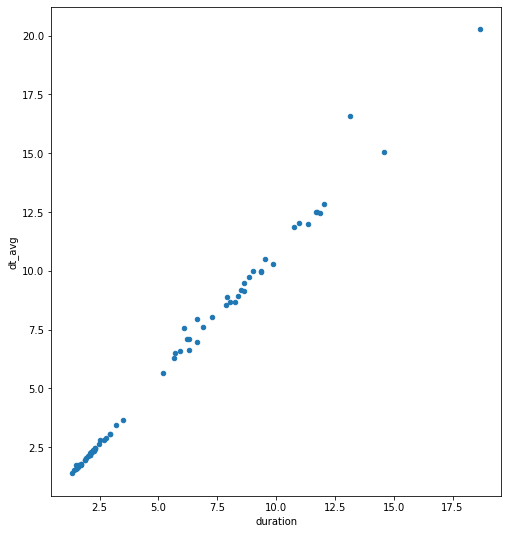

In [0]:
ax = DF_STATS.plot.scatter(x='duration', y='dt_avg', figsize=(9,9));
ax.set_aspect('equal')

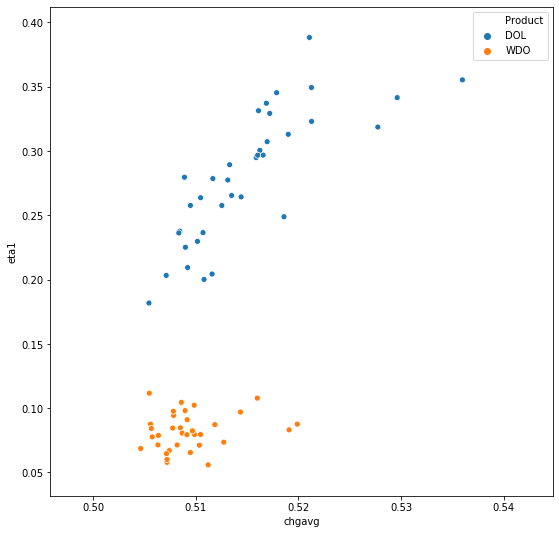

In [0]:
plt.figure(figsize=(9,9))
sns.scatterplot(x='chgavg', y='eta1', hue='Product',\
            data=DF_STATS_PLOT);

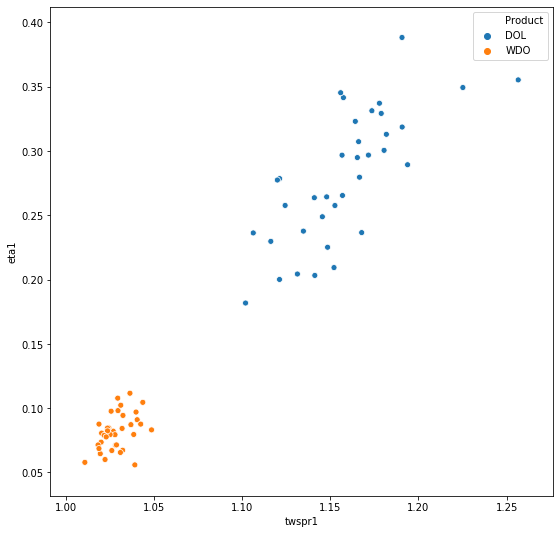

In [0]:
plt.figure(figsize=(9,9))
sns.scatterplot(x='twspr1', y='eta1', hue='Product',\
            data=DF_STATS_PLOT);

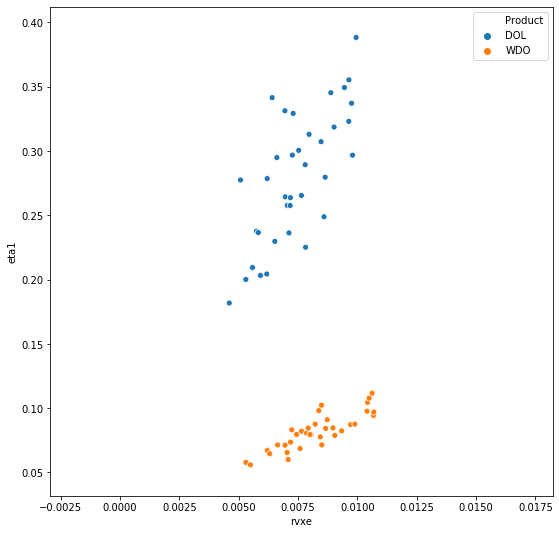

In [0]:
plt.figure(figsize=(9,9))
sns.scatterplot(x='rvxe', y='eta1', hue='Product',\
            data=DF_STATS_PLOT);

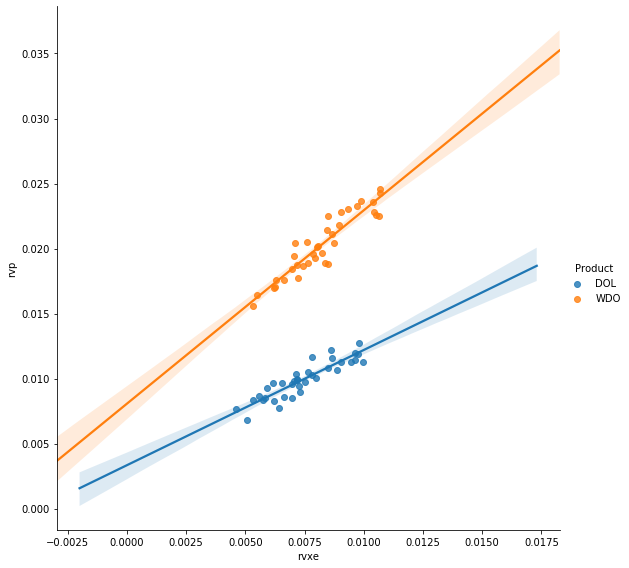

In [0]:
sns.lmplot(x='rvxe', y='rvp', hue='Product', aspect=1, \
            height=8, data=DF_STATS_PLOT);

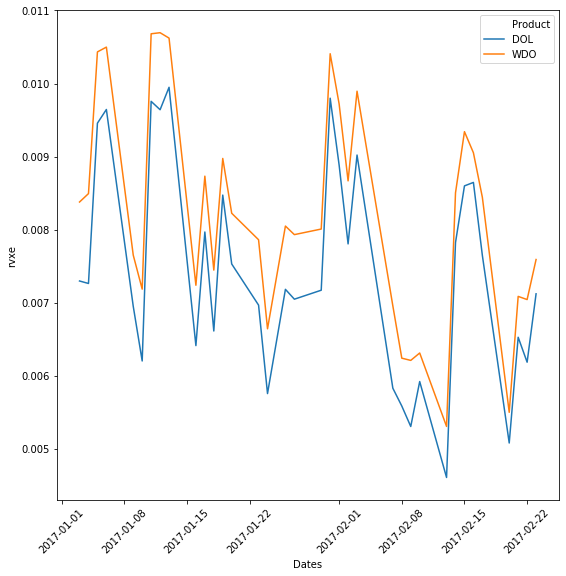

In [0]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='rvxe', hue='Product', data=DF_STATS_PLOT);
plt.xticks(rotation=45);

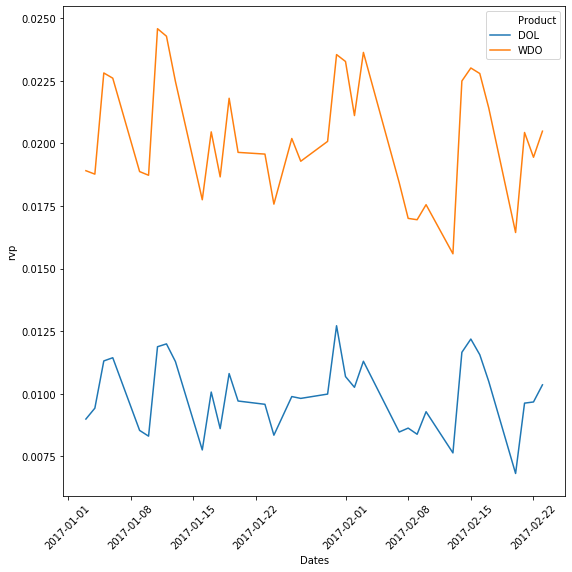

In [0]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='rvp', hue='Product', data=DF_STATS_PLOT);
plt.xticks(rotation=45);

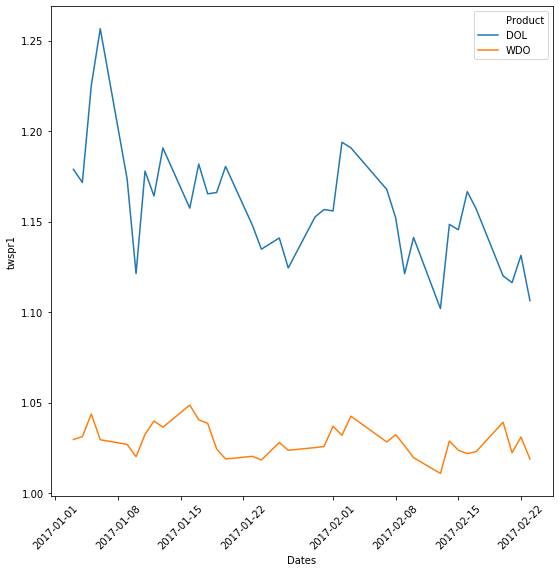

In [0]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='twspr1', hue='Product', data=DF_STATS_PLOT);
plt.xticks(rotation=45);

## States - Orders and Trades

In [0]:
DF_STATS_IMBAL = pd.DataFrame()
for j in range(len(FILESDOL2017)):
    new_row = pd.read_hdf(PATHOUT+FILESDOL2017[j][:-4]+'_OTtrans.h5')
    new_row['Dates'] = DATES_DOL[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESDOL2017[j][:3]
    new_row['Contract'] = FILESDOL2017[j][3:6]
    DF_STATS_IMBAL = DF_STATS_IMBAL.append(new_row)
for j in range(len(FILESWDO2017)):
    new_row = pd.read_hdf(PATHOUT+FILESWDO2017[j][:-4]+'_OTtrans.h5')
    new_row['Dates'] = DATES_WDO[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESWDO2017[j][:3]
    new_row['Contract'] = FILESWDO2017[j][3:6]
    DF_STATS_IMBAL = DF_STATS_IMBAL.append(new_row)
DF_STATS_IMBAL.reset_index()
DF_STATS_IMBAL.set_index(['Product', 'Contract', 'Dates'], inplace=True)
DF_STATS_IMBAL.sort_index(inplace=True)

In [0]:
def get_imbal_mat(product, contract, date):
    mat_values = DF_STATS_IMBAL.loc[product, contract, date].values
    mat_df = pd.DataFrame(mat_values,\
        columns=['Trade_Bid', 'Imbal_Bid',\
            'Neutral', 'Imbal_Ask', 'Trade_Ask'],\
        index=['Trade_Bid', 'Imbal_Bid',\
            'Neutral', 'Imbal_Ask', 'Trade_Ask'])
    return mat_df

In [0]:
def perc_mat(mat, dec=1):
    sum_mat = mat.to_numpy().sum()
    norm_mat = (100*mat/sum_mat)
    norm_mat['Total Cols'] = norm_mat.sum(axis=1)
    norm_mat.loc['Total Rows'] = norm_mat.sum(axis=0)
    return norm_mat.round(dec)

In [0]:
get_imbal_mat('DOL','G17','2017-01-03')

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask
Trade_Bid,4725,2613,1749,647,2
Imbal_Bid,1635,43989,3138,1529,1287
Neutral,2059,2904,69373,2994,1999
Imbal_Ask,1317,1542,3312,39878,1409
Trade_Ask,0,530,1758,2409,5149


In [0]:
get_imbal_mat('WDO','G17','2017-01-03')

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask
Trade_Bid,36799,12068,8302,4739,423
Imbal_Bid,9426,103967,4482,665,5750
Neutral,9884,2835,99162,2979,9364
Imbal_Ask,5855,647,4583,104565,8621
Trade_Ask,367,4773,7695,11323,34515


In [0]:
perc_mat(get_imbal_mat('DOL','G17','2017-01-03'))

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,2.4,1.3,0.9,0.3,0.0,4.9
Imbal_Bid,0.8,22.2,1.6,0.8,0.7,26.1
Neutral,1.0,1.5,35.0,1.5,1.0,40.1
Imbal_Ask,0.7,0.8,1.7,20.1,0.7,24.0
Trade_Ask,0.0,0.3,0.9,1.2,2.6,5.0
Total Rows,4.9,26.1,40.1,24.0,5.0,100.0


In [0]:
perc_mat(get_imbal_mat('WDO','G17','2017-01-03'))

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,7.5,2.4,1.7,1.0,0.1,12.6
Imbal_Bid,1.9,21.1,0.9,0.1,1.2,25.2
Neutral,2.0,0.6,20.1,0.6,1.9,25.2
Imbal_Ask,1.2,0.1,0.9,21.2,1.7,25.2
Trade_Ask,0.1,1.0,1.6,2.3,7.0,11.9
Total Rows,12.6,25.2,25.2,25.2,11.9,100.0


In [0]:
perc_mat(get_imbal_mat('DOL','G17','2017-01-04'))

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,2.2,1.1,0.7,0.3,0.0,4.3
Imbal_Bid,0.6,22.1,1.4,0.7,0.6,25.5
Neutral,0.8,1.3,35.6,1.4,0.8,40.0
Imbal_Ask,0.6,0.7,1.5,22.7,0.6,26.1
Trade_Ask,0.0,0.3,0.7,1.0,2.1,4.1
Total Rows,4.3,25.5,40.0,26.1,4.1,100.0


In [0]:
perc_mat(get_imbal_mat('WDO','G17','2017-01-04'))

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,7.1,2.5,1.5,0.8,0.1,12.0
Imbal_Bid,1.9,21.8,1.0,0.1,1.1,25.8
Neutral,1.8,0.6,20.9,0.7,1.8,25.9
Imbal_Ask,1.0,0.1,1.0,21.2,1.8,25.0
Trade_Ask,0.1,0.8,1.5,2.3,6.6,11.3
Total Rows,12.0,25.8,25.9,25.0,11.3,100.0


## States - Depletions and Fills

In [0]:
DF_STATS_DEPL = pd.DataFrame()
for j in range(len(FILESDOL2017)):
    new_row = pd.read_hdf(PATHOUT+FILESDOL2017[j][:-4]+'_RDFtrans.h5')
    new_row['Dates'] = DATES_DOL[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESDOL2017[j][:3]
    new_row['Contract'] = FILESDOL2017[j][3:6]
    DF_STATS_DEPL = DF_STATS_DEPL.append(new_row)
for j in range(len(FILESWDO2017)):
    new_row = pd.read_hdf(PATHOUT+FILESWDO2017[j][:-4]+'_RDFtrans.h5')
    new_row['Dates'] = DATES_WDO[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESWDO2017[j][:3]
    new_row['Contract'] = FILESWDO2017[j][3:6]
    DF_STATS_DEPL = DF_STATS_DEPL.append(new_row)
DF_STATS_DEPL.reset_index()
DF_STATS_DEPL.set_index(['Product', 'Contract', 'Dates'], inplace=True)
DF_STATS_DEPL.sort_index(inplace=True)

In [0]:
def get_depl_mat(product, contract, date):
    mat_values = DF_STATS_DEPL.loc[product, contract, date].values
    mat_cols = pd.MultiIndex.from_tuples(\
        [('same', ' D C '),\
        ('same', ' D T '),\
        ('same', 'D T+F'),\
        ('same', '  F  '),\
        ('oppo', ' D C '),\
        ('oppo', ' D T '),\
        ('oppo', 'D T+F'),\
        ('oppo', '  F  ')])
    mat_df = pd.DataFrame(mat_values,\
        columns=mat_cols,\
        index=[' D C ', ' D T ',\
            'D T+F', '  F  '])
    return mat_df

In [0]:
get_depl_mat('DOL','G17','2017-01-03')

same                    oppo                  
       D C   D T  D T+F   F    D C   D T  D T+F   F  
 D C      4     4    73  2283     3     3   105   225
 D T      9    62   168  1541    14    14   708   492
D T+F    59    60    99   594    23    21   208   297
  F    2000  1252     0    24   588  1593     0   101

In [0]:
get_depl_mat('WDO','G17','2017-01-03')

same                    oppo                  
       D C   D T  D T+F   F    D C   D T  D T+F   F  
 D C      0     0     3  1986     0     2   286    36
 D T      3    46   126  4240     1     6   836   920
D T+F     1     8    32  1030     0     3   227   211
  F    1200  2264     1    19  1108  3850     1    23

In [0]:
perc_mat(get_depl_mat('DOL','G17','2017-01-03'))

same                    oppo                   Total Cols
            D C   D T  D T+F   F    D C   D T  D T+F   F             
 D C         0.0   0.0   0.6  18.1   0.0   0.0   0.8   1.8       21.4
 D T         0.1   0.5   1.3  12.2   0.1   0.1   5.6   3.9       23.8
D T+F        0.5   0.5   0.8   4.7   0.2   0.2   1.6   2.4       10.8
  F         15.8   9.9   0.0   0.2   4.7  12.6   0.0   0.8       44.0
Total Rows  16.4  10.9   2.7  35.2   5.0  12.9   8.1   8.8      100.0

In [0]:
perc_mat(get_depl_mat('WDO','G17','2017-01-03'))

same                    oppo                   Total Cols
            D C   D T  D T+F   F    D C   D T  D T+F   F             
 D C         0.0   0.0   0.0  10.8   0.0   0.0   1.5   0.2       12.5
 D T         0.0   0.2   0.7  23.0   0.0   0.0   4.5   5.0       33.5
D T+F        0.0   0.0   0.2   5.6   0.0   0.0   1.2   1.1        8.2
  F          6.5  12.3   0.0   0.1   6.0  20.8   0.0   0.1       45.8
Total Rows   6.5  12.6   0.9  39.4   6.0  20.9   7.3   6.4      100.0

In [0]:
perc_mat(get_depl_mat('DOL','G17','2017-01-04'))

same                    oppo                   Total Cols
            D C   D T  D T+F   F    D C   D T  D T+F   F             
 D C         0.0   0.0   0.3  19.5   0.0   0.0   1.0   1.7       22.6
 D T         0.0   0.6   1.2  11.9   0.2   0.1   5.1   4.1       23.1
D T+F        0.4   0.4   0.8   4.6   0.1   0.1   1.2   2.0        9.6
  F         16.7   9.4   0.0   0.2   5.2  12.5   0.0   0.7       44.7
Total Rows  17.1  10.4   2.3  36.3   5.5  12.7   7.3   8.4      100.0

In [0]:
perc_mat(get_depl_mat('WDO','G17','2017-01-04'))

same                    oppo                   Total Cols
            D C   D T  D T+F   F    D C   D T  D T+F   F             
 D C         0.0   0.0   0.0  11.8   0.0   0.0   1.8   0.2       13.8
 D T         0.0   0.1   0.7  22.1   0.0   0.0   4.4   4.6       32.0
D T+F        0.0   0.1   0.2   5.7   0.0   0.0   1.3   1.1        8.5
  F          7.0  11.5   0.0   0.1   6.8  20.2   0.0   0.1       45.7
Total Rows   7.0  11.7   1.0  39.7   6.8  20.3   7.5   6.0      100.0

## Dataframe of price changes by k

In [0]:
DF_STATS_MOVES = pd.DataFrame()
for j in range(len(FILESDOL2017)):
    new_row = pd.read_hdf(PATHOUT+FILESDOL2017[j][:-4]+'_CAticks.h5')
    new_row['Dates'] = DATES_DOL[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESDOL2017[j][:3]
    new_row['Contract'] = FILESDOL2017[j][3:6]
    DF_STATS_MOVES = DF_STATS_MOVES.append(new_row)
for j in range(len(FILESWDO2017)):
    new_row = pd.read_hdf(PATHOUT+FILESWDO2017[j][:-4]+'_CAticks.h5')
    new_row['Dates'] = DATES_WDO[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESWDO2017[j][:3]
    new_row['Contract'] = FILESWDO2017[j][3:6]
    DF_STATS_MOVES = DF_STATS_MOVES.append(new_row)
DF_STATS_MOVES.reset_index()
DF_STATS_MOVES.set_index(['Product', 'Contract', 'Dates'], inplace=True)
DF_STATS_MOVES.sort_index(inplace=True)

In [0]:
def get_moves_mat(product, contract, date):
    mat_values = DF_STATS_MOVES.loc[product, contract, date].values
    mat_df = pd.DataFrame(mat_values,\
        columns=['Move in ticks', 'lambda',\
            'Continuations', 'Alternations', 'u', 'eta'],)
    return mat_df

In [0]:
def get_lambda1_mat():
    sub_mat = DF_STATS_MOVES.copy().reset_index()
    sub_mat = sub_mat[sub_mat['Li']==1]\
        [['Product', 'Contract', 'Dates', 'lamb']]
    return sub_mat

In [0]:
get_moves_mat('DOL','G17','2017-01-03')

,Move in ticks,lambda,Continuations,Alternations,u,eta
0,1.0,0.966530,1240.0,1820.0,0.340659,0.329257
1,2.0,0.032523,18.0,85.0,-0.288235,-0.009374
2,3.0,0.000947,0.0,3.0,-1.000000,-0.000947


In [0]:
get_moves_mat('WDO','G17','2017-01-03')

,Move in ticks,lambda,Continuations,Alternations,u,eta
0,1.0,0.986951,2358.0,11861.0,0.099401,0.098104
1,2.0,0.011245,5.0,157.0,-0.468153,-0.005264
2,3.0,0.000555,0.0,7.0,-1.000000,-0.000555
3,4.0,0.000416,0.0,6.0,-1.500000,-0.000625
4,5.0,0.000278,1.0,3.0,-1.166667,-0.000324
5,6.0,0.000347,0.0,5.0,-2.500000,-0.000868
6,7.0,0.000069,0.0,1.0,-3.000000,-0.000208
7,8.0,0.000069,0.0,1.0,-3.500000,-0.000243
8,9.0,0.000069,0.0,1.0,-4.000000,-0.000278


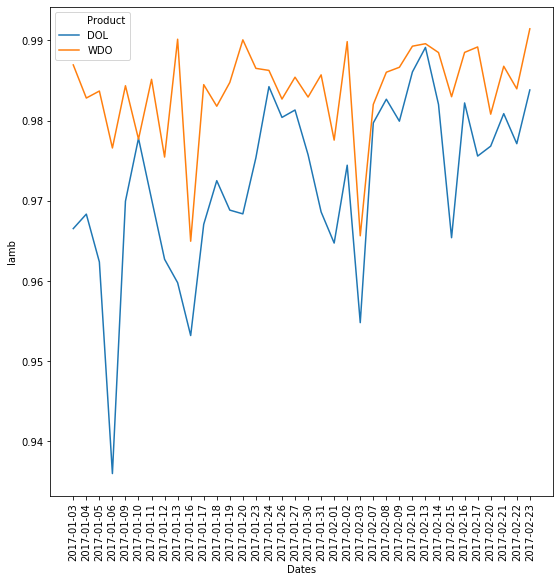

In [0]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='lamb', hue='Product', data=get_lambda1_mat());
plt.xticks(rotation=90);

In [0]:
#DOL_MEAN_COST[DOL_MEAN_COST['Trade Qty']<=300].plot.scatter(x='Trade Qty', y='Avg_Cost');